In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp

from Thermodynamics.DOF import *
from System_SterileNuDM import System_SterileNuDM
from Make_Rate_Table import Make_Table
from Asy_Redistribution import eqs_redist
from Thermodynamics.Thermo_quantities import Thermo_quantities

from Constants import *
from Momentum_Grid import *
from Tolerances import *
from Sterile_Nu_Parameters import *

In [2]:
#Making the table of the neutrino interaction rates

Gamma_a_Table = np.zeros((ni_Table,nT_Table)) #numbers of momentum and temperature grid
Gamma_a_anti_Table = np.zeros((ni_Table,nT_Table))

Gamma_a_Table, Gamma_a_anti_Table = Make_Table(La_ini,Le_ini,Lmu_ini,Ltau_ini,flavor)

In [3]:
#Solving the system

#Temperature range

Tini = 1e4 #MeV
Tfin = 15 

#initial condition for sterile neutrinos and lepton asymmetry mixing with nus

f_nus_0 = np.zeros(n)
f_nus_anti_0 = np.zeros(n)
La_0 = np.zeros(1)

La_0[0] = La_ini


#Initial values for thermodynamics quantities 

x0 = np.array([0,0,0,0,0])

ans0 =  sp.optimize.root(eqs_redist, x0, args = (Tini,La_ini,Le_ini,Lmu_ini,Ltau_ini,flavor), method='hybr',tol=tol_root)  

zeta_nue0 = ans0.x[0]
zeta_numu0 = ans0.x[1]
zeta_nutau0 = ans0.x[2]

zeta_e0 = ans0.x[0] - ans0.x[4]
zeta_mu0 = ans0.x[1] - ans0.x[4]
zeta_tau0 = ans0.x[2] - ans0.x[4]

zeta_B0 = ans0.x[3]

zeta_Q0 = ans0.x[4]

rho0, s0, P0, Delta_rho0, rho_nua0, rho_a0, Del_nua0, Del_a0, Del_nu_total0, Del_c_total0, Del_Q_QCD0 \
          = Thermo_quantities(Tini,zeta_nue0,zeta_numu0,zeta_nutau0,zeta_B0,zeta_Q0,flavor)

#Solving the system of the sterile neutrino production

sys_values_0 = np.concatenate((f_nus_0,f_nus_anti_0,La_0))
    
T_span = [Tini,Tfin] 

T_eval = np.logspace(np.log10(Tini),np.log10(Tfin),1000)
#T_eval = [Tfin]

argList = [Gamma_a_Table,Gamma_a_anti_Table,s0,ms,Uas,Le_ini,Lmu_ini,Ltau_ini,flavor]


sol = solve_ivp(System_SterileNuDM,T_span,sys_values_0,t_eval=T_eval,args=argList,method='RK23',atol=atol_ivp,rtol=rtol_ivp)


In [4]:
#DM abundance at the current Universe

n_nus = 0

for ni in range(n):

    y = y_sterile[ni]
    dy = dy_sterile[ni]

    n_nus += dy*y**2*(sol.y[ni,-1] + sol.y[ni+n,-1])

n_nus *= 1/(2*np.pi**2)

gs_today = gs_below120MeV(1e-2)

s_today = 2*np.pi**2/45*gs_today

Ttoday = 2.73*8.617*1e-5*1e-6 #K->eV->MeV #2.726?

h=0.673

rho_cr = 1.878*1e-29*h**2 #g cm^-3

rho_cr *= (0.511*3.862*1e-11)**3 # g cm^-3 -> g MeV^3
rho_cr *= 0.511/9.109*1e28 #g MeV^3->MeV^4

#Sterile neutrino abudance normalized by the observed DM abundance
Omega_nus = ms*Ttoday**3*(s_today/s0)/rho_cr*n_nus*1/0.265 

print(Omega_nus)

0.9967686469711059


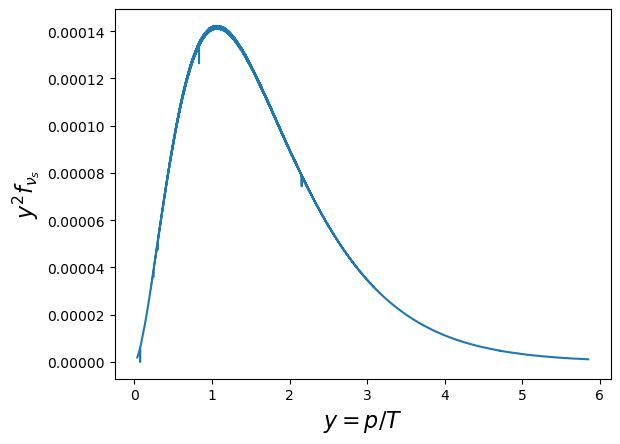

In [7]:
#Sterile neutrino distribution in the current Universe
#For a smoother spectrum, better tolerances are necessary.

y_sterile_com = np.zeros(n)
fs = np.zeros(n)

for ni in range(n):
    
    y_sterile_com[ni] = (s_today/s0)**(1/3)*y_sterile[ni] 
    fs[ni] = (s_today/s0)**(2/3)*y_sterile[ni]**2*sol.y[ni,-1]

plt.plot(y_sterile_com,fs,'-')
plt.xlabel(r'$y=p/T$',fontsize=16)
plt.ylabel(r'$y^2f_{\nu_s}$',fontsize=16)
plt.show()

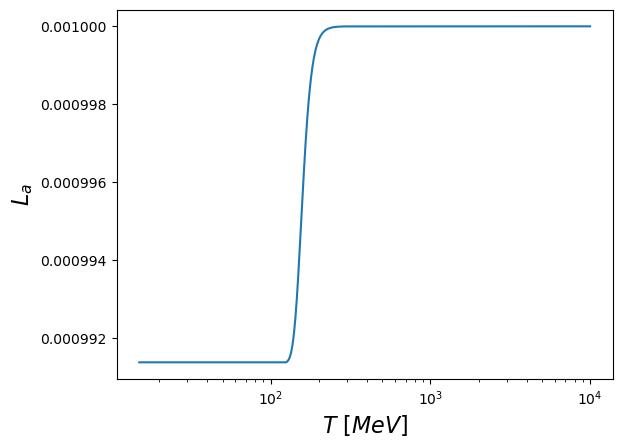

In [8]:
#Evolution of lepton asymmetry mixing with sterile neutrinos

l = len(sol.t)

L_eval = np.zeros(l)
T_eval = np.zeros(l)

for nt in range(l):
    
    T_eval[nt] = sol.t[nt]
    
    L_eval[nt] = sol.y[2*n,nt]


plt.semilogx(T_eval,L_eval,'-')
plt.xlabel(r'$T\ [MeV]$',fontsize=16)
plt.ylabel(r'$L_a$',fontsize=16)
plt.show()